# LCE per PMT

In [1]:
## Check Python version:
!python -V
## Check ROOT version:
!which root

Python 3.7.3


In [2]:
## Imports:

import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec            # to arrange the plots nicely
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence
import random

In [3]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

## Properties PMTs

<img src="../../Technical_Drawings_and_Data_Sheets/PMTs/pmts_verbessert.png" alt="pmts_verbessert.png" style="width: 700px;"/>

In [4]:
PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

,PMT_ID,PMT_position_x,PMT_position_y,PMT_position_R,PMT_position_Phi
1,1,-14.0,-28.0,31.304952,-2.034444
2,2,-28.0,0.0,28.000000,3.141593
3,3,-14.0,28.0,31.304952,2.034444
4,4,14.0,28.0,31.304952,1.107149
5,5,28.0,0.0,28.000000,0.000000
6,6,14.0,-28.0,31.304952,-1.107149
7,7,0.0,0.0,0.000000,0.000000


In [5]:
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

## Imports and data porcessing

In [6]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Modification_Spacer_3
#! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters
! ls /media/ab602/TOSHIBA\ EXT/Simulation_Data/LCE
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/LCE

optPhot_S1_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root
optPhot_S1_1.0e+07_pmtGap0_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run01.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run02.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run03.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run04.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run05.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_run06.root
optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_wri

In [7]:
## Selection of file to be analyzed:
filename = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root'


# filename prefix for automatically naming outputs

if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]
    
elif filename[6:25] == 'Simulation_Data/Mod':
    filenameprefix = filename[:-5][44:]
    
elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]
    
elif filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][45:]
    
elif filename[:63] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][63:]
    
elif filename[:70] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][70:]
    
elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][44:]
    
elif filename[:62] == '/media/alex/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][62:]
    
elif filename[:69] == '/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][69:]

else:
    filenameprefix = 'filenameprefix'
    
print(filenameprefix)

optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04


In [8]:
## Import as pandas dataframes

import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('\n')
    
if filenameprefix.find('nop') > 0:
    nop_string = filenameprefix[(filenameprefix.find('nop')+4) : (filenameprefix.find('+', filenameprefix.find('nop')+4)+3)]
    exec('nop = '+nop_string)
    print('nop = '+str(nop))
    _chunk_collect['nbpmthits'] = _chunk_collect['nbpmthits'] / nop
    _chunk_collect['ntpmthits'] = _chunk_collect['ntpmthits'] / nop
    _chunk_collect['pmthits'] = _chunk_collect['pmthits'] / nop
else:
    print('Error: Number of particles per event = 1!')

.

nop = 10000.0


/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


In [9]:
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')

0 1 2 3 4 5 6 7 

In [10]:
## Total PMT hits
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)
_chunk_collect['napmthits'].shape

(100000,)

In [11]:
_chunk_collect.head(6)

,xp_pri,yp_pri,zp_pri,nbpmthits,ntpmthits,pmthits,pmthits_0,pmthits_1,pmthits_2,pmthits_3,pmthits_4,pmthits_5,pmthits_6,pmthits_7,napmthits
0,4.791938,27.147135,2.528008,0.1458,0.1263,"[0.1458, 0.0029, 0.0069, 0.0291, 0.0568, 0.010...",0.1458,0.0029,0.0069,0.0291,0.0568,0.0106,0.0029,0.0171,0.2721
1,-11.615876,17.197851,4.247355,0.1428,0.1341,"[0.1428, 0.004, 0.0222, 0.0592, 0.013, 0.0045,...",0.1428,0.0040,0.0222,0.0592,0.0130,0.0045,0.0035,0.0277,0.2769
2,12.733964,-20.782236,2.551565,0.1375,0.1323,"[0.1375, 0.0138, 0.0054, 0.0028, 0.005, 0.0185...",0.1375,0.0138,0.0054,0.0028,0.0050,0.0185,0.0657,0.0211,0.2698
3,20.555264,-17.673210,4.955978,0.1305,0.1282,"[0.1305, 0.0075, 0.0042, 0.0034, 0.0052, 0.033...",0.1305,0.0075,0.0042,0.0034,0.0052,0.0337,0.0602,0.0140,0.2587
4,-13.297334,7.453089,3.023084,0.1435,0.1350,"[0.1435, 0.0077, 0.0382, 0.0255, 0.0082, 0.006...",0.1435,0.0077,0.0382,0.0255,0.0082,0.0062,0.0056,0.0436,0.2785
5,-4.685884,-25.539049,4.875433,0.1370,0.1332,"[0.137, 0.0661, 0.0092, 0.0034, 0.0027, 0.0061...",0.1370,0.0661,0.0092,0.0034,0.0027,0.0061,0.0279,0.0178,0.2702


## Photons per PMT histograms

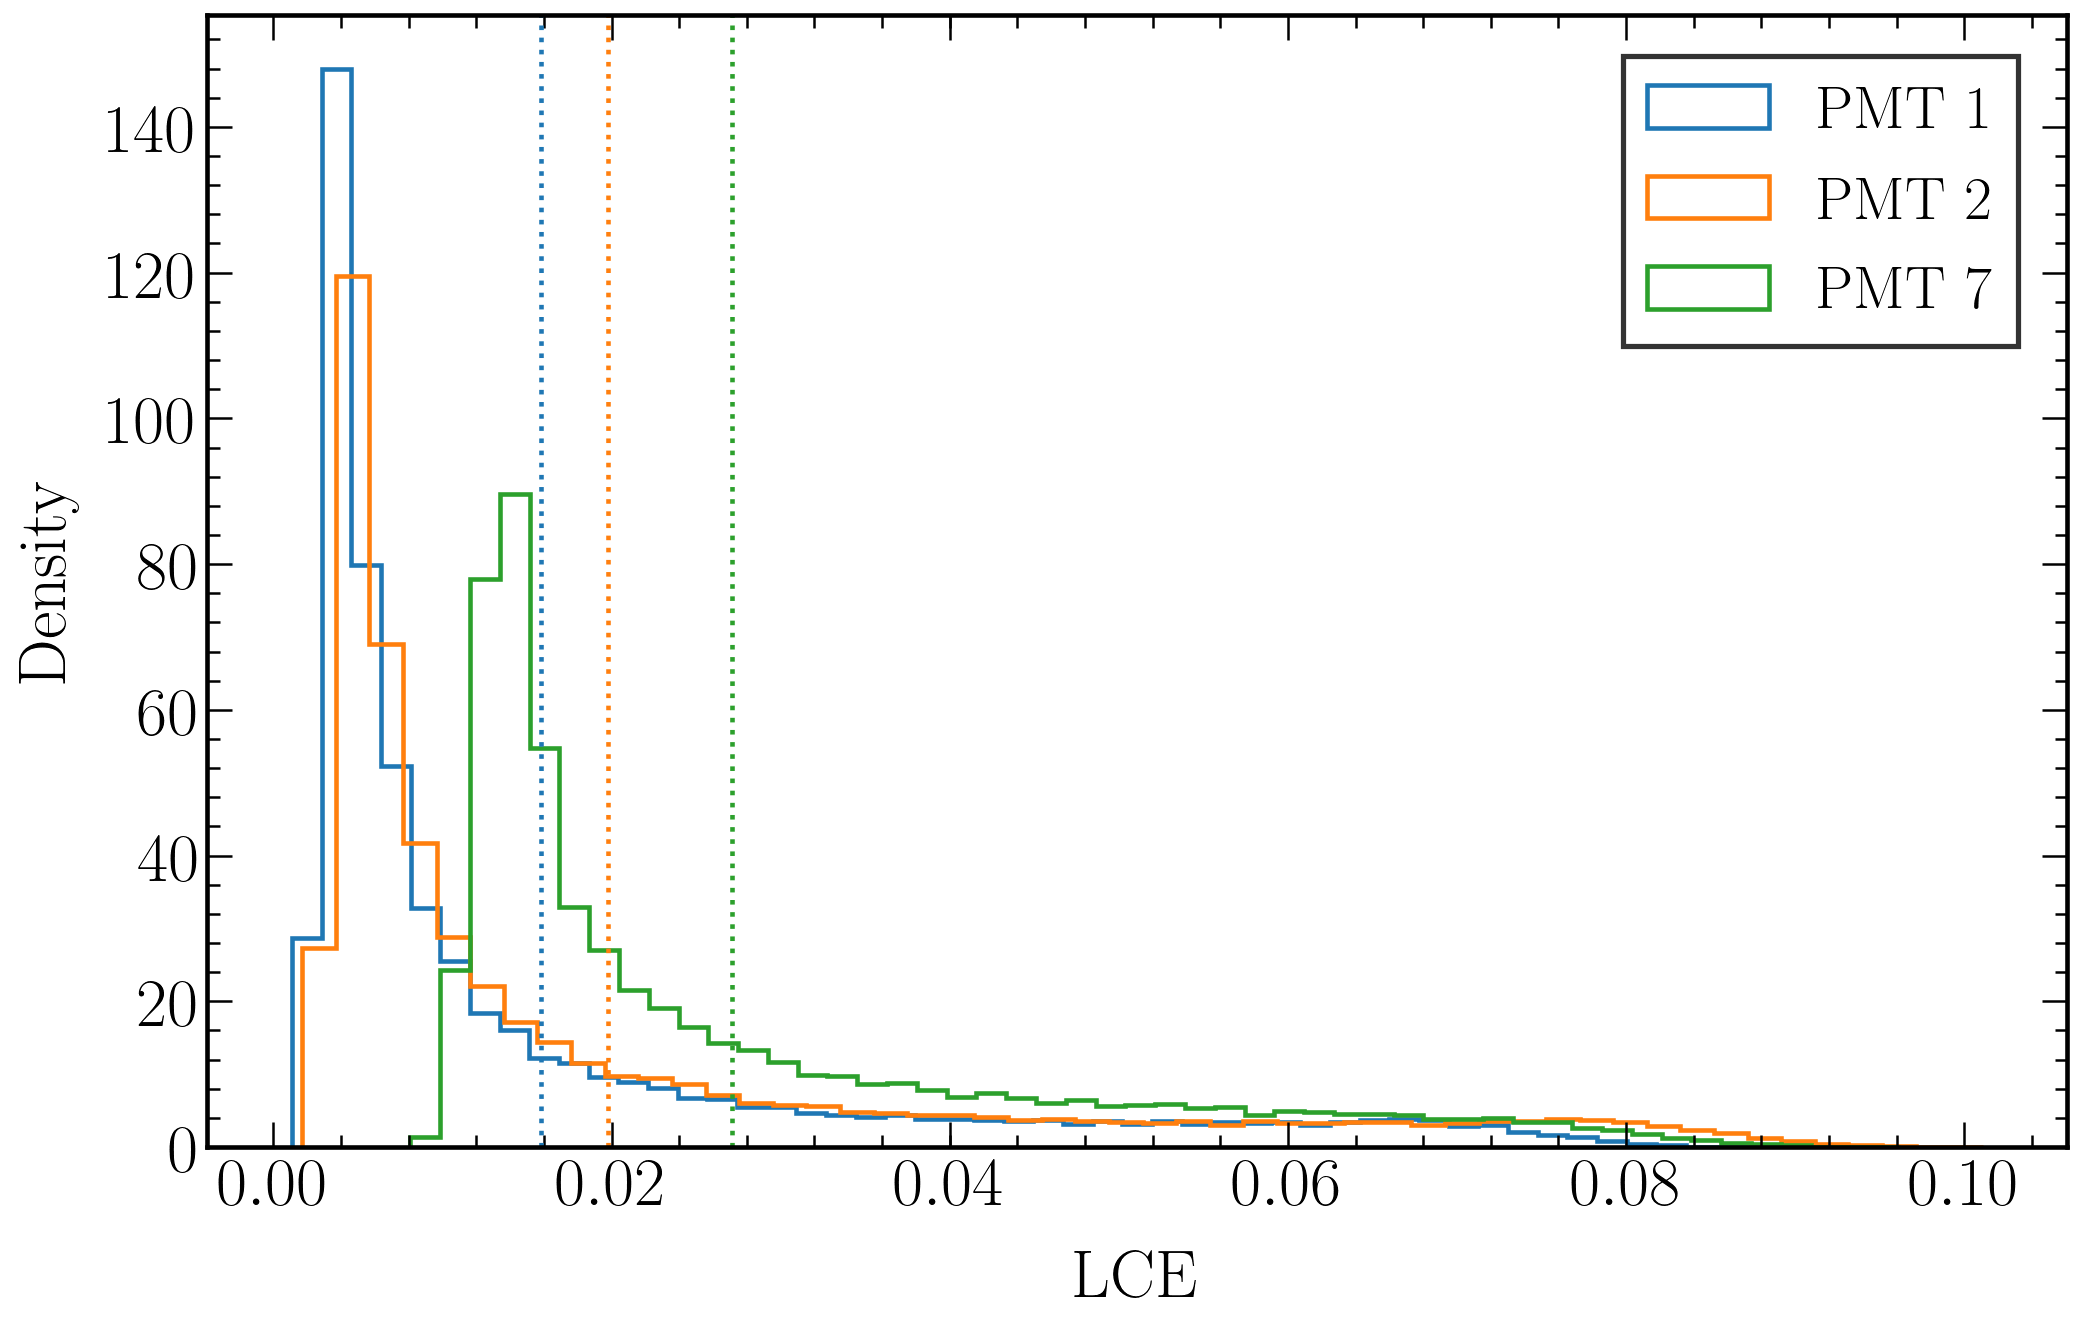

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_1'], bins = 50, histtype='step', linewidth = 2.2, label = 'PMT 1', density = True, color = 'C0')
plt.axvline(x=_chunk_collect['pmthits_1'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['pmthits_2'], bins = 50, histtype='step', linewidth = 2.2, label = 'PMT 2', density = True, color = 'C1')
plt.axvline(x=_chunk_collect['pmthits_2'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')
plt.hist(_chunk_collect['pmthits_7'], bins = 50, histtype='step', linewidth = 2.2, label = 'PMT 7', density = True, color = 'C2')
plt.axvline(x=_chunk_collect['pmthits_7'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C2')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT127_hist.png")
plt.show()

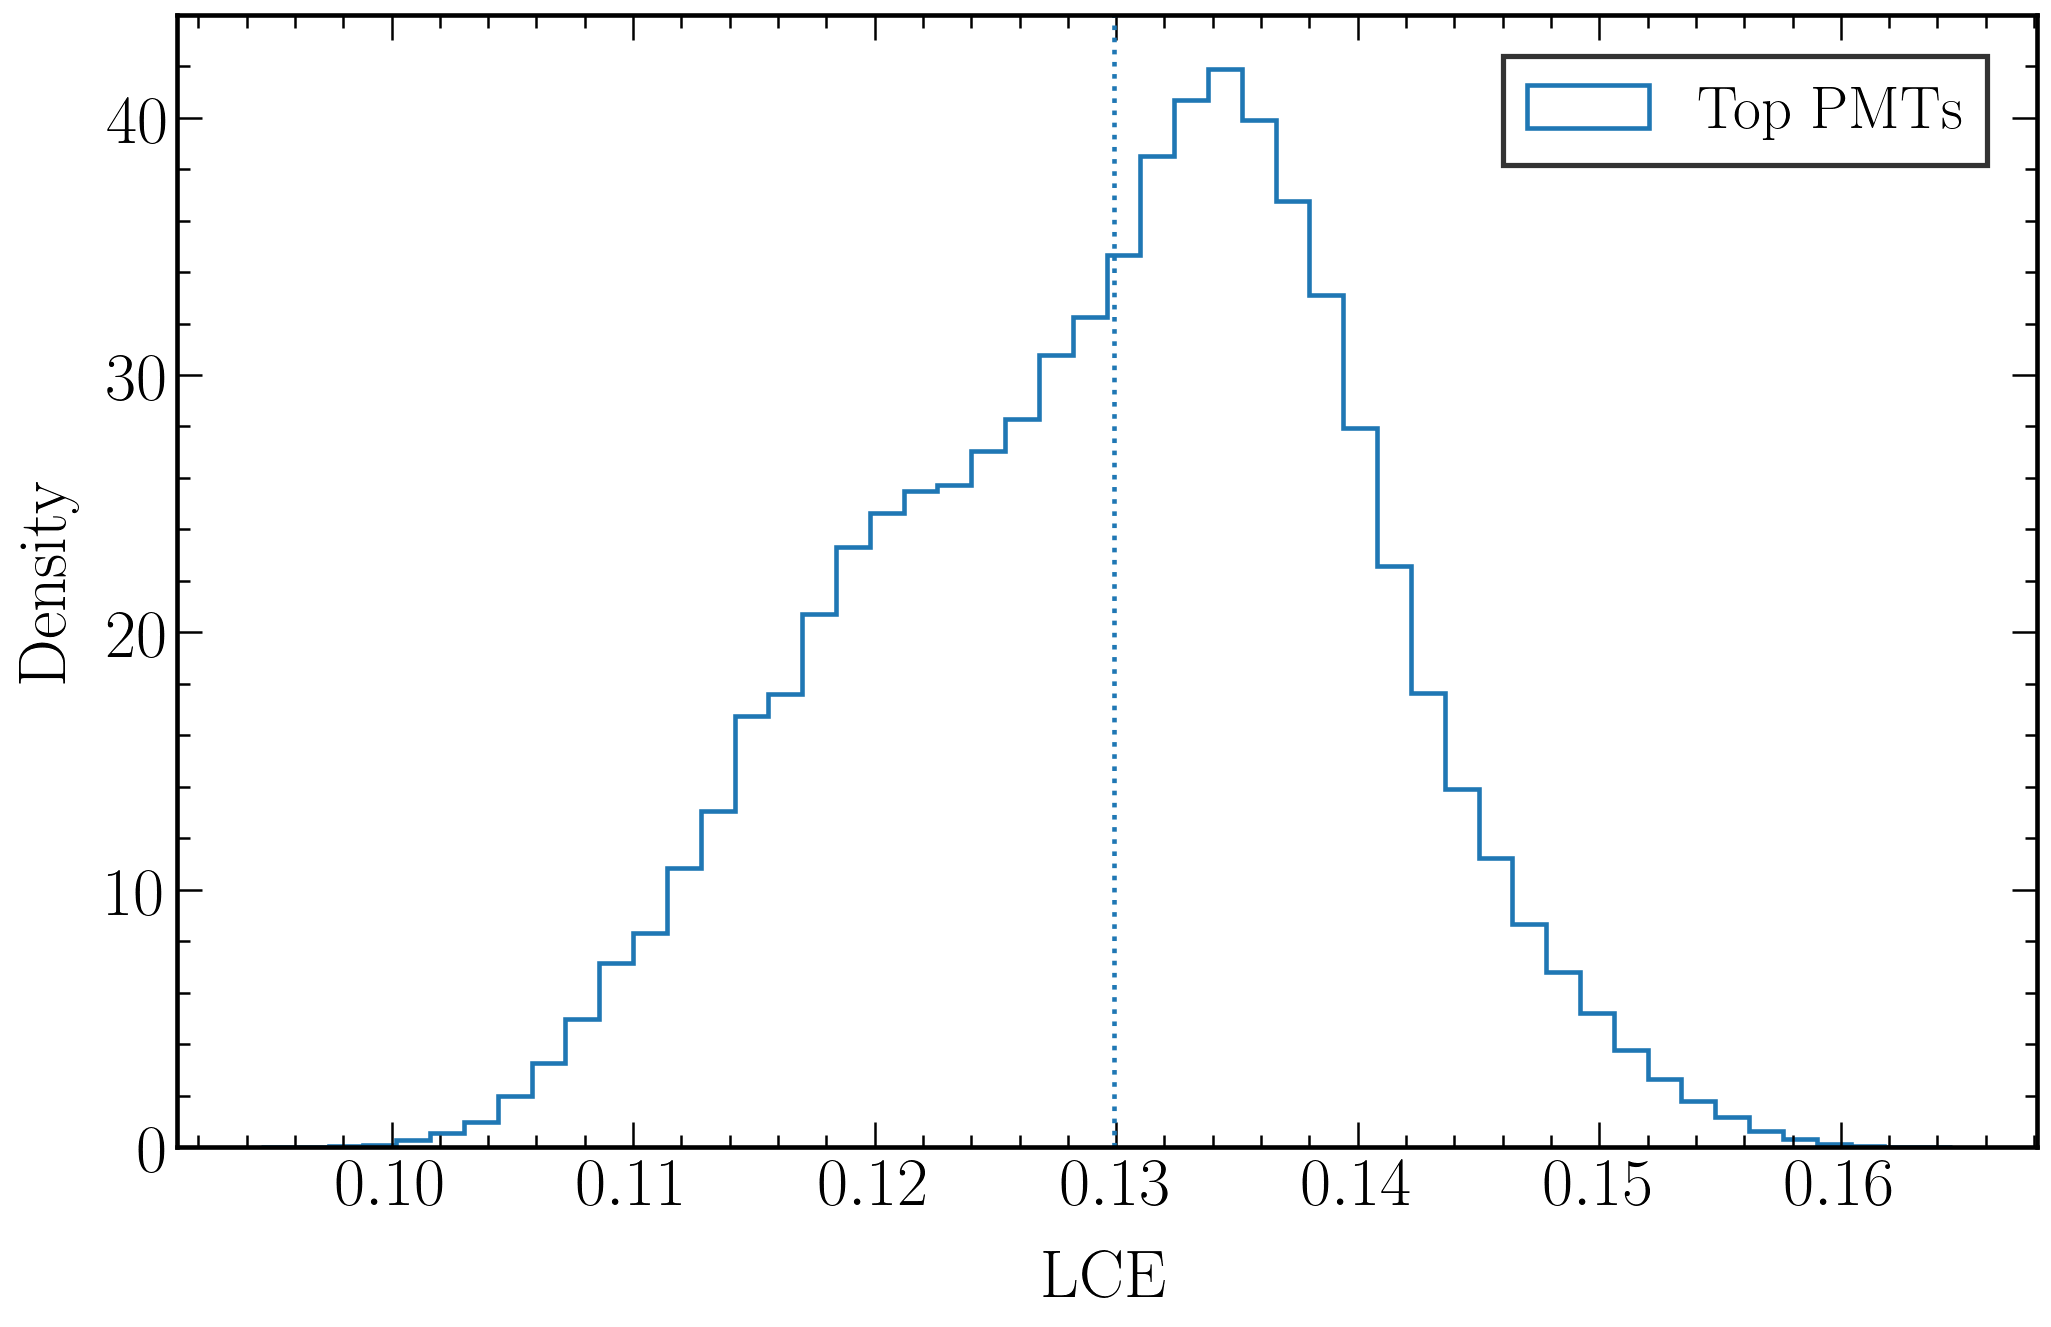

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', label = 'Top PMTs')
plt.axvline(x=_chunk_collect['ntpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTtop_hist.png")
plt.show()

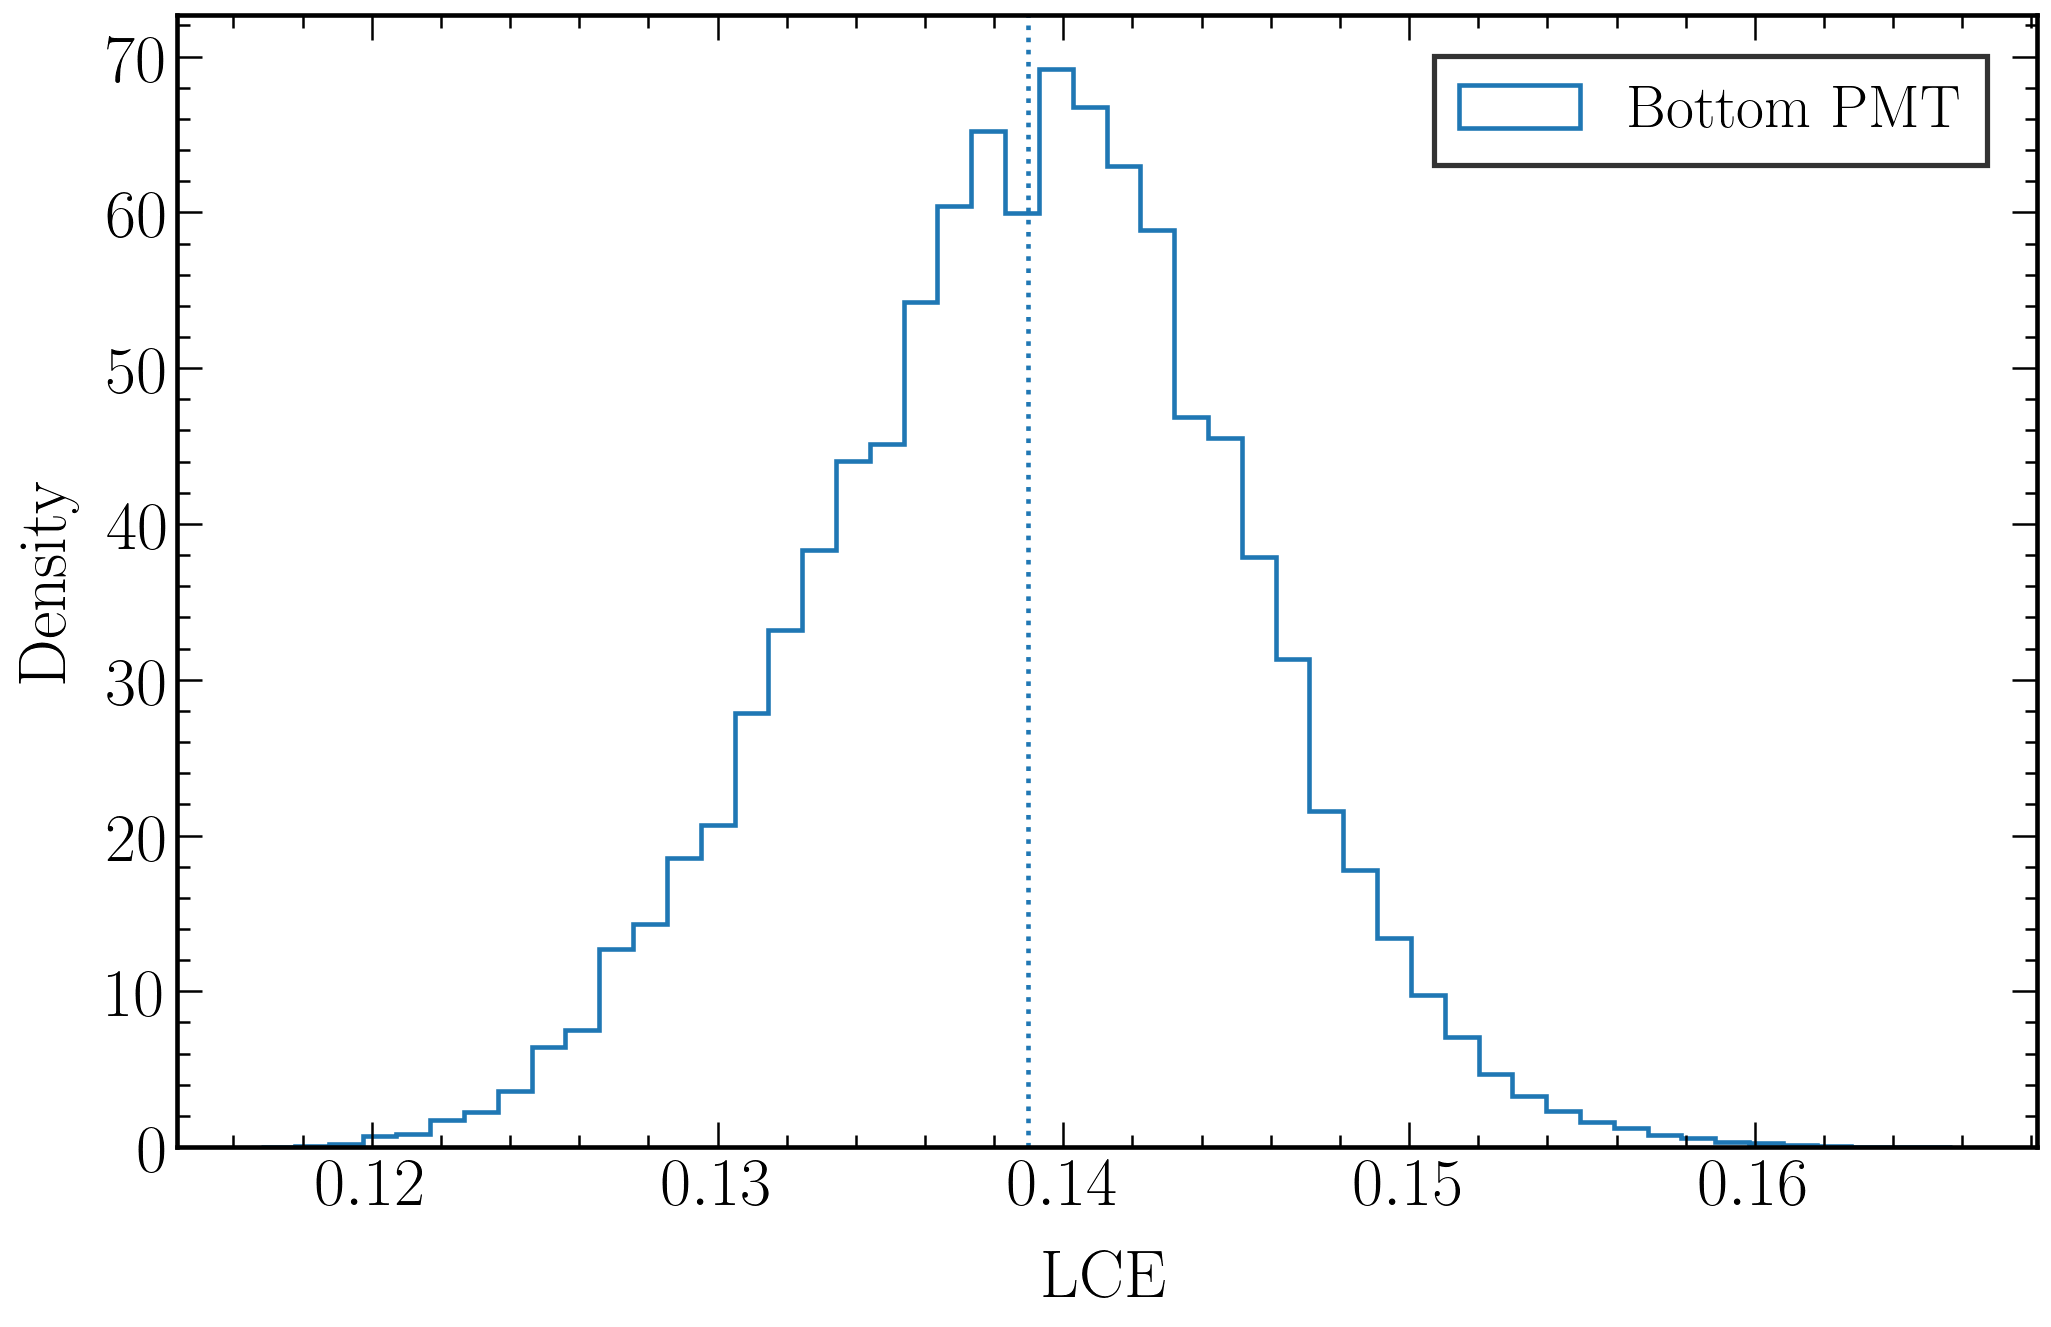

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['nbpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', label = 'Bottom PMT')
plt.axvline(x=_chunk_collect['nbpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTbottom_hist.png")
plt.show()

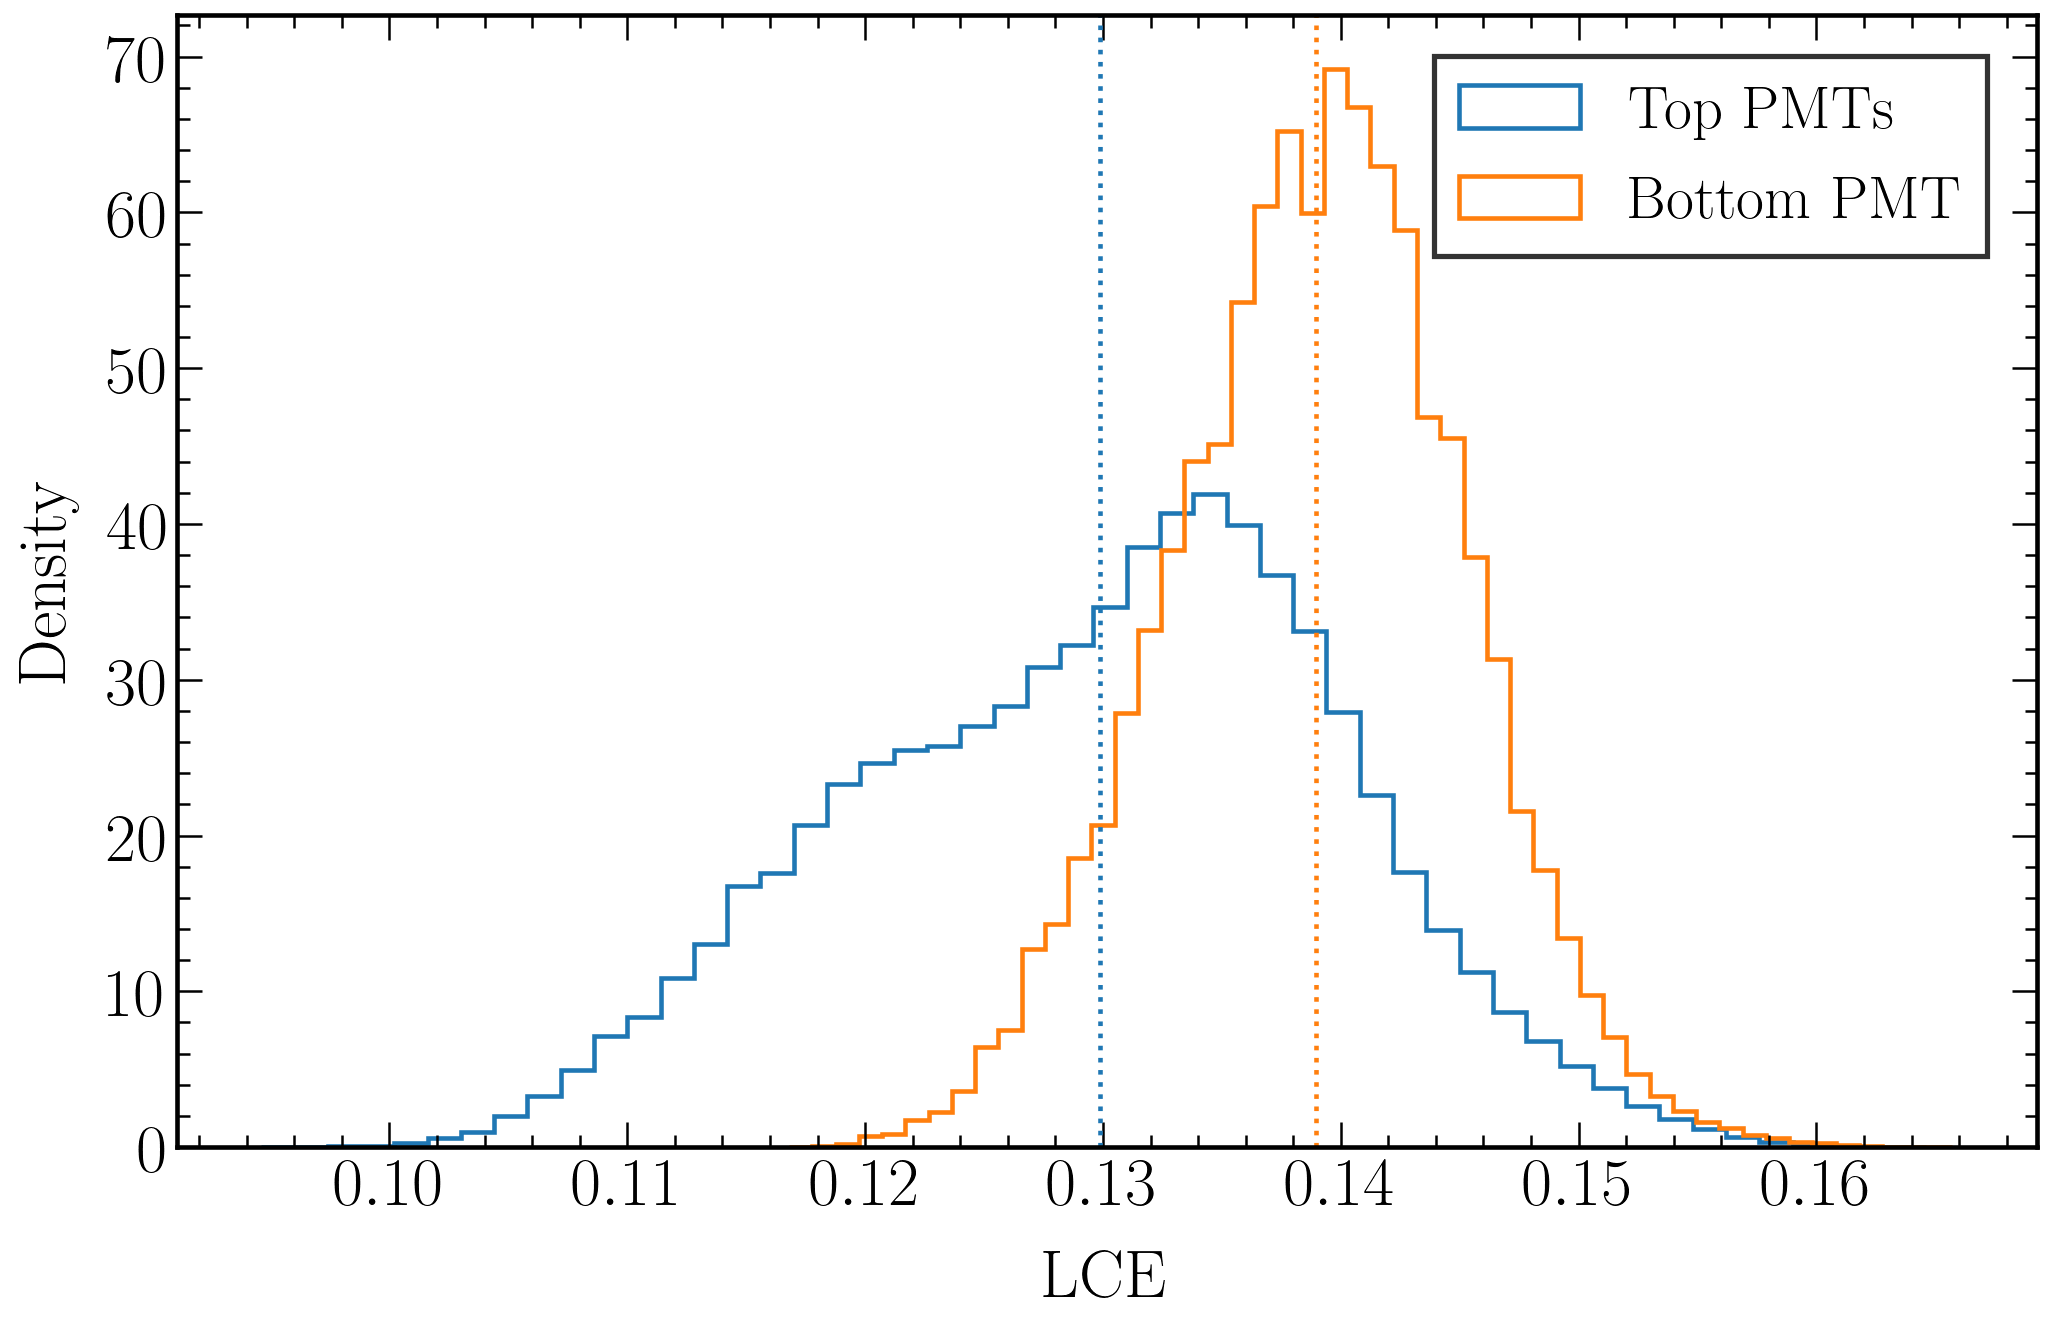

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['ntpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C0', label = 'Top PMTs')
plt.axvline(x=_chunk_collect['ntpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C0')
plt.hist(_chunk_collect['nbpmthits'], bins = 50, histtype='step', linewidth = 2.2, density = True, color = 'C1', label = 'Bottom PMT')
plt.axvline(x=_chunk_collect['nbpmthits'].mean(), linewidth = 2.2, linestyle = 'dotted', color = 'C1')

plt.xlabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMTbottomtop_hist.png")
plt.show()

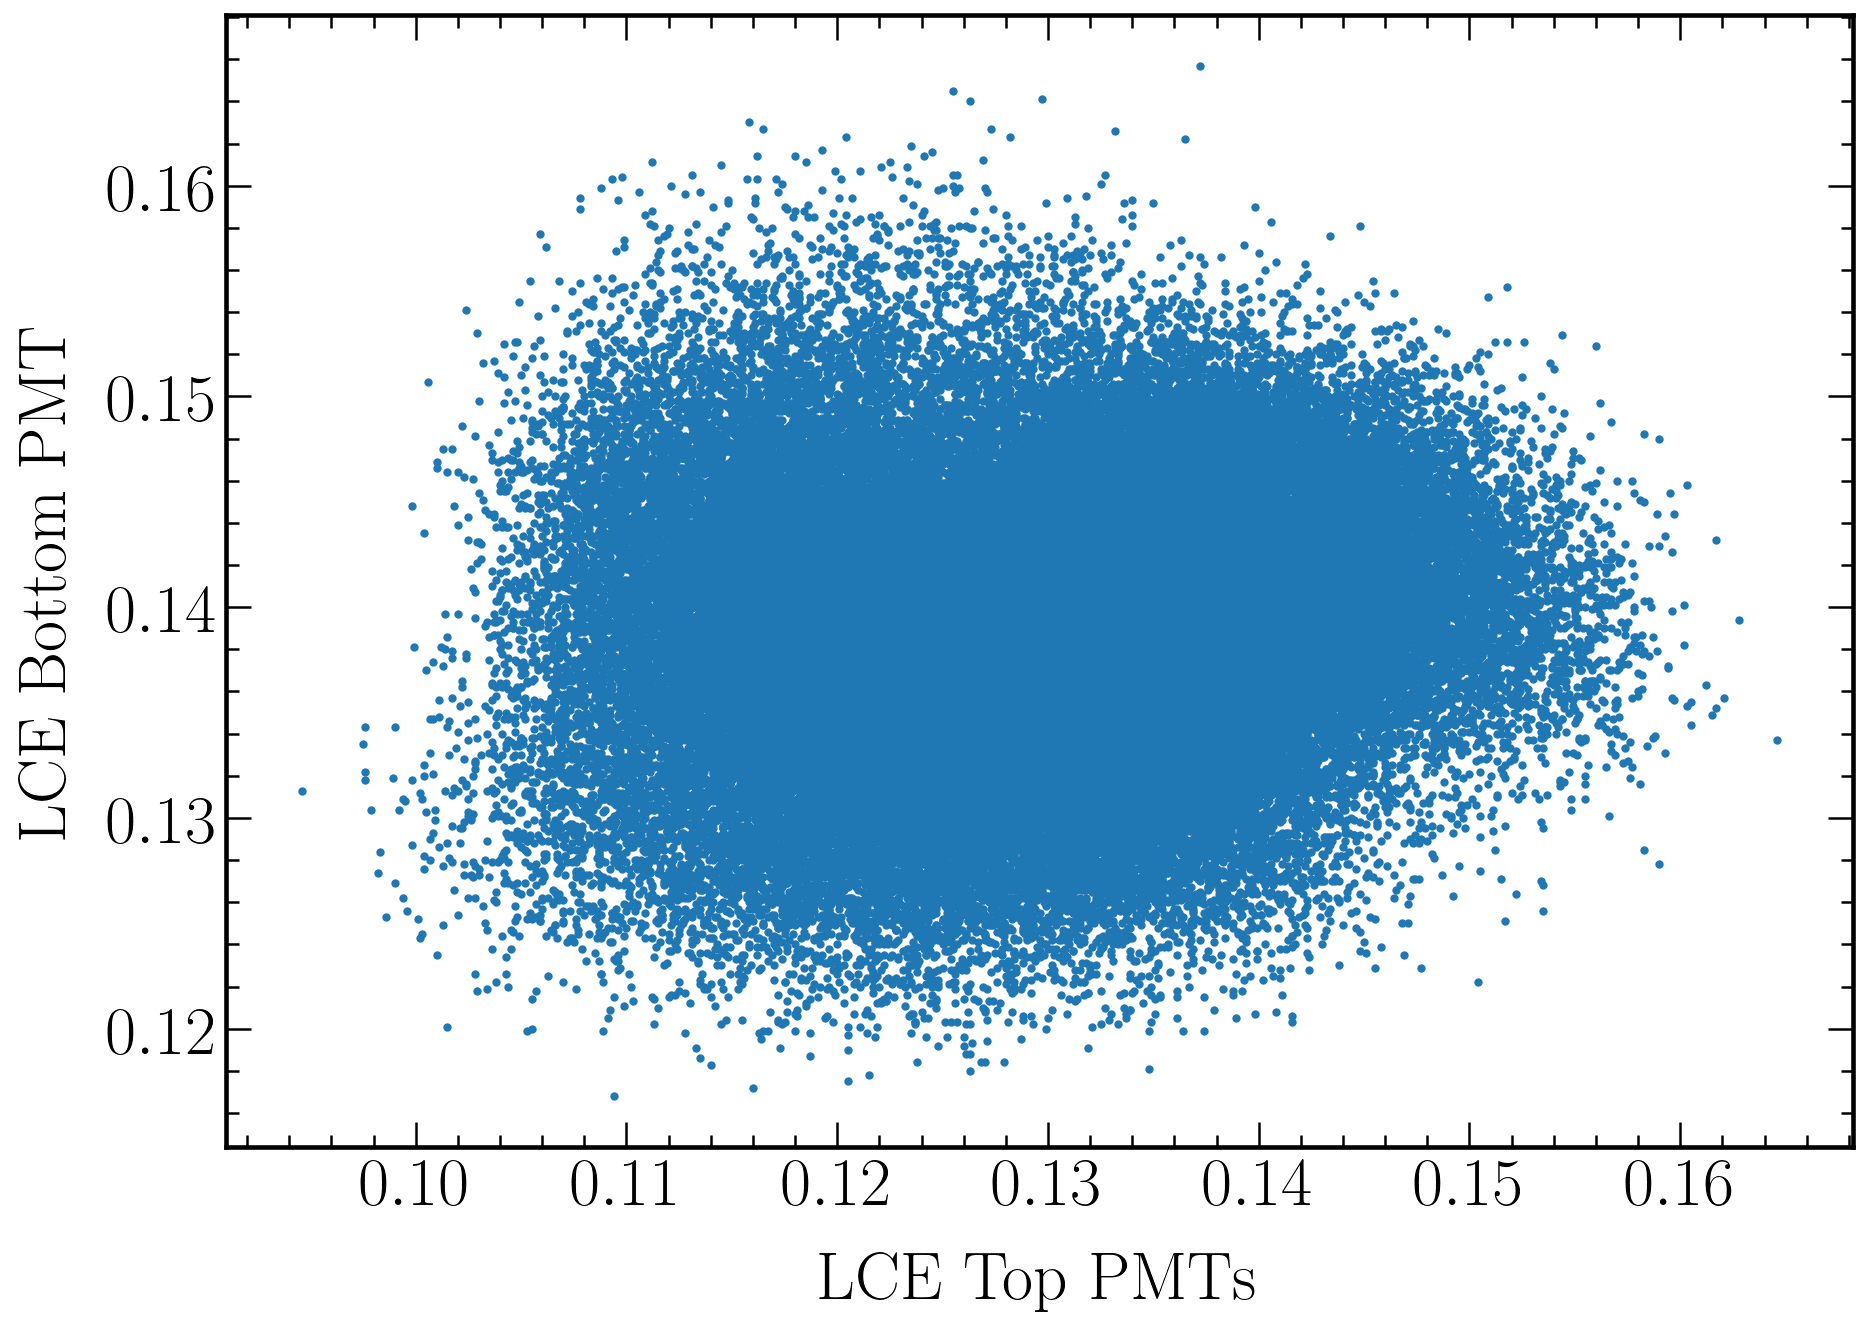

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(14, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('equal')
plt.scatter(_chunk_collect['ntpmthits'], _chunk_collect['nbpmthits'], marker = '.')

plt.xlabel('LCE Top PMTs', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE Bottom PMT', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

fig.savefig(filenameprefix+"_LCE_PMTbottomtop_scatter.png")
plt.show()

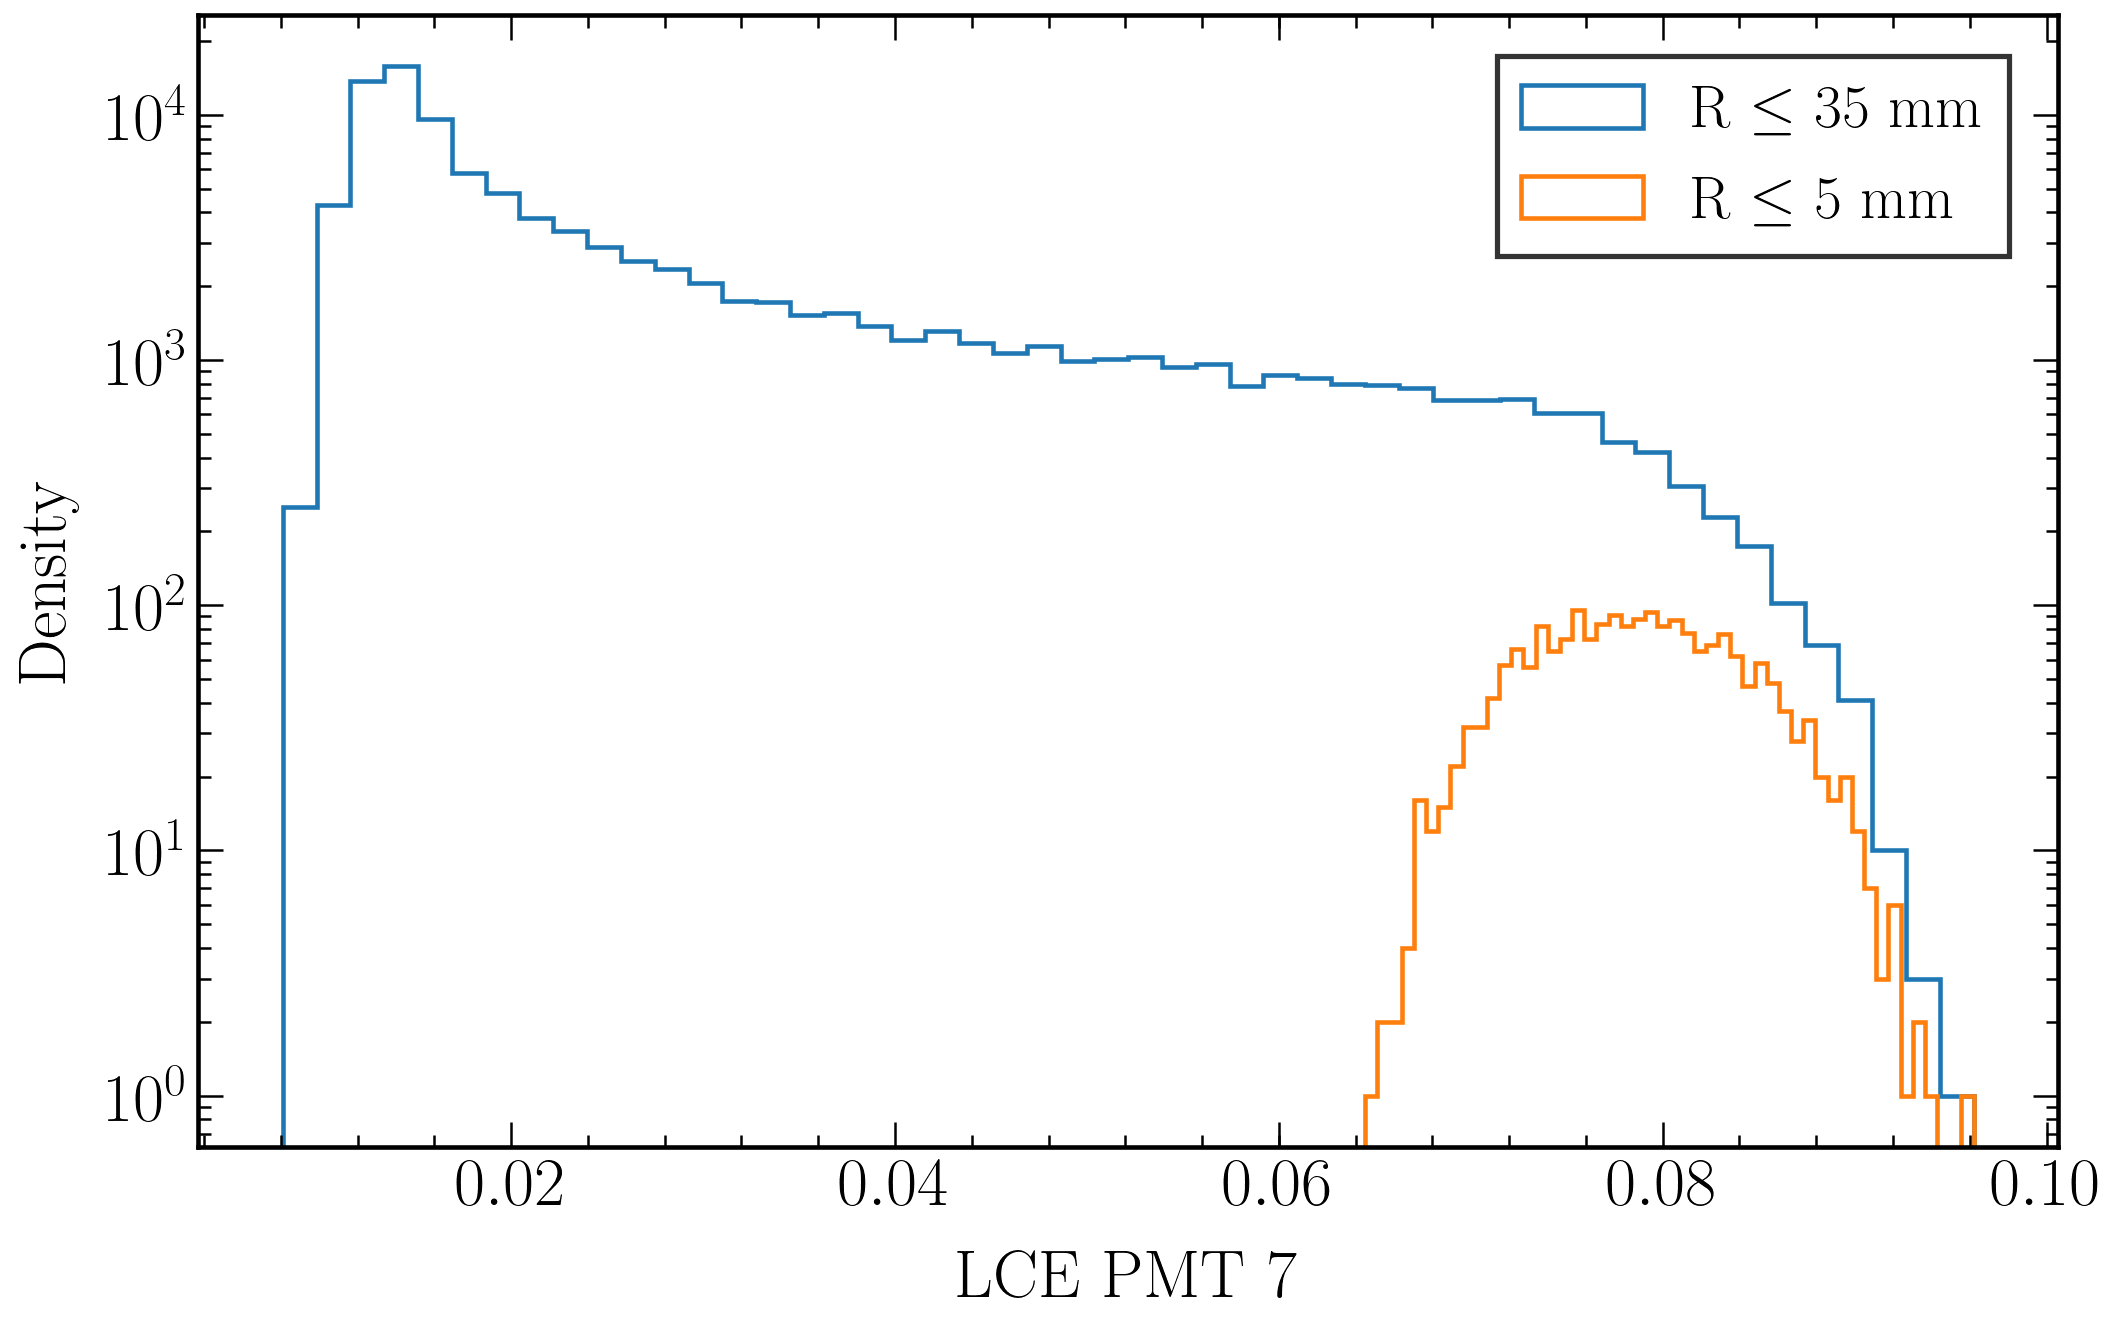

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.hist(_chunk_collect['pmthits_7'], bins = 50, histtype='step', linewidth = 2.2, label = 'R $\leq$ 35 mm')
plt.hist(_chunk_collect['pmthits_7'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) <= 5], bins = 50, histtype='step', linewidth = 2.2, label = 'R $\leq$ 5 mm')
plt.yscale('log')

plt.xlabel('LCE PMT 7', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Density', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT7_conf_hist.png")
plt.show()

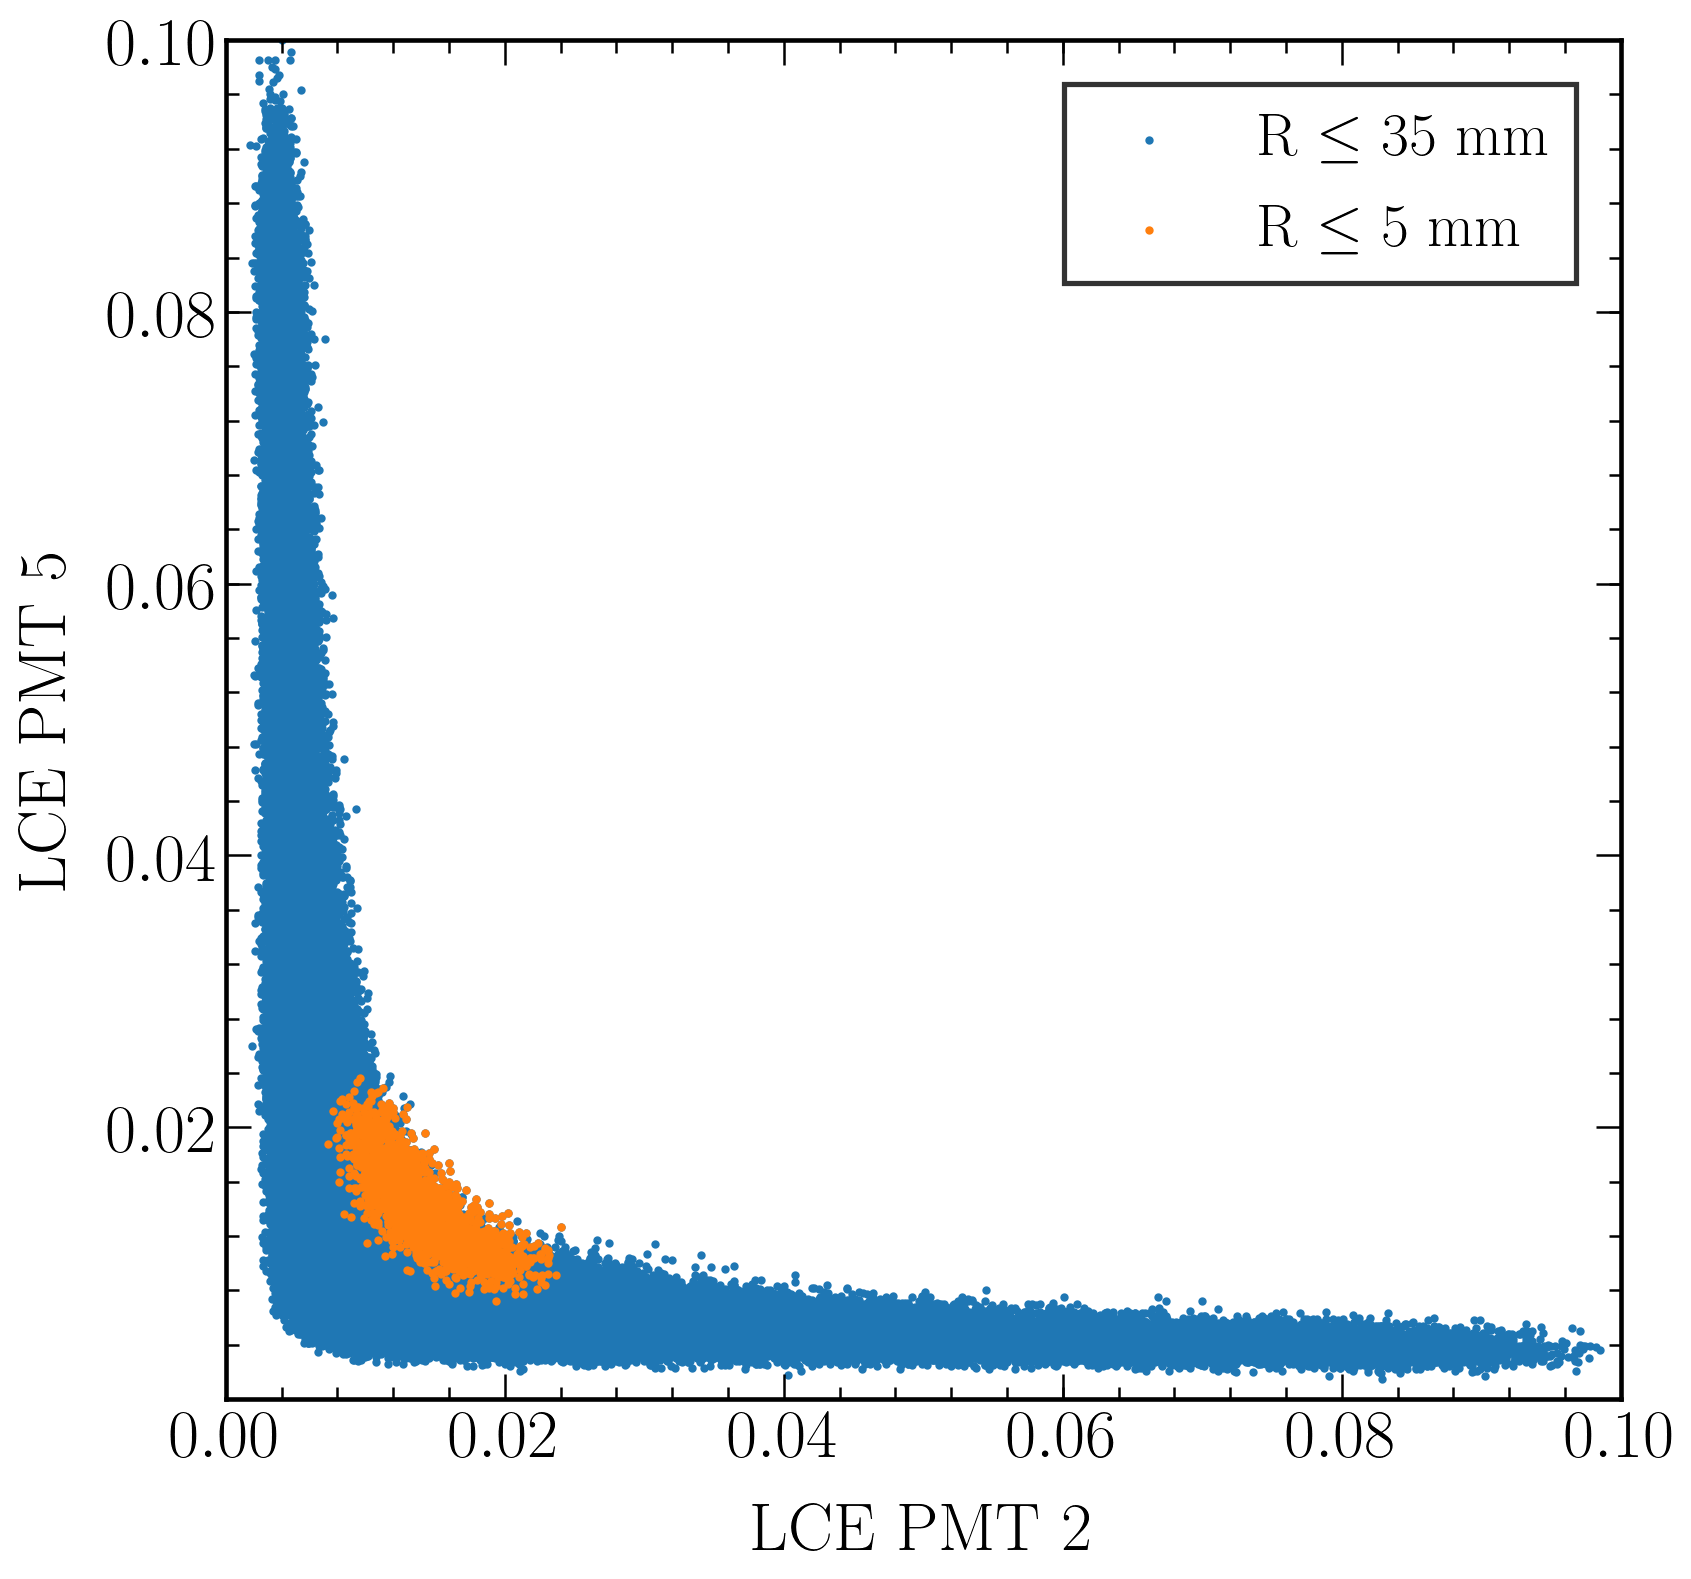

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(12, 12), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot

plt.scatter(_chunk_collect['pmthits_2'], _chunk_collect['pmthits_5'], marker = '.', label = 'R $\leq$ 35 mm')
ct = 5
plt.scatter(_chunk_collect['pmthits_2'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) < ct], _chunk_collect['pmthits_5'][np.sqrt(_chunk_collect['xp_pri']**2 + _chunk_collect['yp_pri']**2) < ct], marker = '.', label = 'R $\leq$ '+str(ct)+' mm')
plt.ylim(bottom = 0)
plt.xlim(left = 0)

plt.xticks(np.arange(0.0, 0.11, 0.02))
plt.yticks(np.arange(0.02, 0.11, 0.02))
plt.xlim(0.0, 0.1)
plt.ylim(0.0, 0.1)

plt.xlabel('LCE PMT 2', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE PMT 5', fontsize = label_size, labelpad = label_pad)
#plt.title('LCE per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_LCE_PMT25_scatter.png")
plt.show()